In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from utils.experiment_utils import *
from utils.trading_model import *

from cvx.covariance.combination import from_sigmas
from cvx.covariance.ewma import _ewma_cov, iterated_ewma

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2


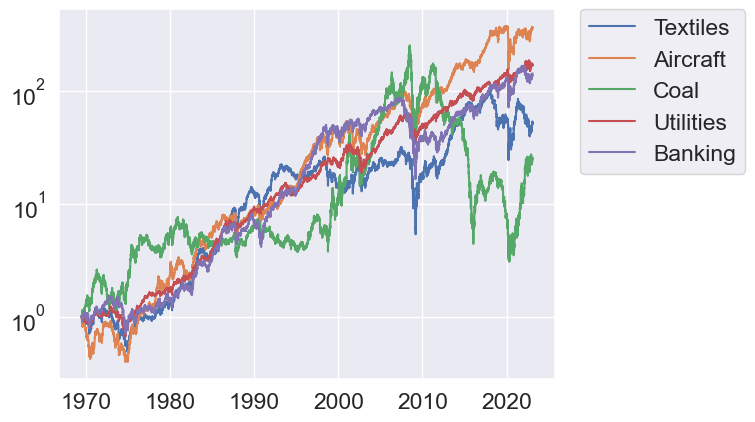

In [10]:
columns = ["Txtls", "Aero", "Coal", "Util", "Banks"]
labels = ["Textiles", "Aircraft", "Coal", "Utilities", "Banking"]
plt.plot((returns[columns]+1).cumprod(axis=0), label=labels)
# fix legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale("log");

# Import data

In [2]:
returns = pd.read_csv('data/49_industries.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# Covariance predictors

In [3]:
### Parameters
rw_memory = 500
ewma_halflife=250
iewma_pair = (125,250)
cm_iewma_pairs = [(21, 63), (63, 125), (125, 250), (250, 500), (500, 1000)]

In [4]:
# Rolling window 
rw = rolling_window(returns, rw_memory) 

In [5]:
# EWMA
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))

In [6]:
# IEWMA  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0], cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

Next we import the precomputed MGARCH predictors (computed using the rmgarch
package in R). We used the first 250 days for training. Hence the first
predictors is given at day 250, and predicts the covariance matrix for day 251.
(Python uses zero-based indexing, so the first predictor will have time index 249.)

In [7]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov_split = []
n_chunks = 15
for i in range(n_chunks):
    mgarch_cond_cov_split.append(pd.read_csv("mgarch_predictors_from_R/49_industries/mgarch_49_industries_{}.csv".format(i+1), index_col=0))
mgarch_cond_cov = pd.concat(mgarch_cond_cov_split)

Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = returns.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

In [8]:
# CM-IEWMA
cm_iewma_pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)] 

iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10, solver="ECOS"))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

In [18]:
# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

# Define end and start dates for backtests

In [19]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1971-06-24", format="%Y-%m-%d")
# start_date = pd.to_datetime("2000-01-03", format="%Y-%m-%d")
# start_date = pd.to_datetime("2010-01-04", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [20]:
names = ["RW", "EWMA", "IEWMA", "CM-IEWMA", "MGARCH", "PRESCIENT"]
predictors_temp = [rw, ewma, iewma, cm_iewma, mgarch, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# CM-IEWMA component weights

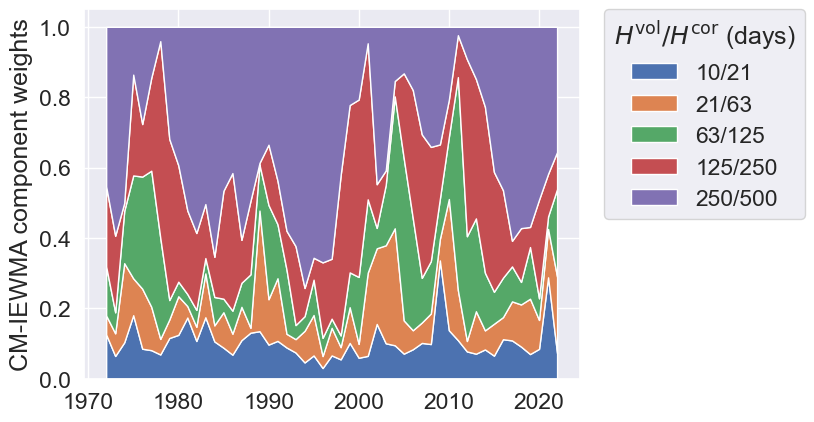

In [14]:
yearly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

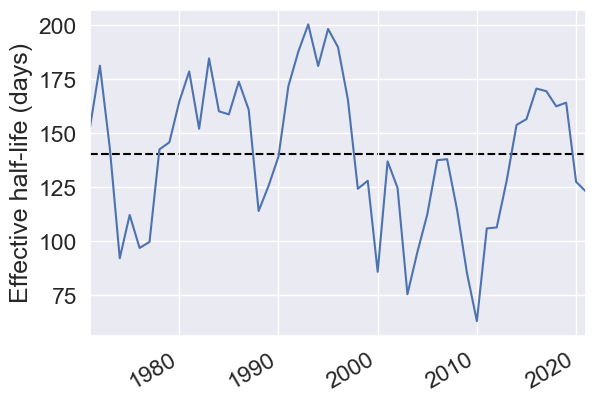

In [15]:
halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(yearly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((yearly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1)
plt.ylabel("Effective half-life (days)")
plt.gcf().autofmt_xdate()

# MSEs

In [16]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("Q").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.6f}")
    print(f"std: {MSE_temp.std():.6f}")
    print(f"max: {MSE_temp.max():.6f}")
    


RW
mean: 0.000761
std: 0.004010
max: 0.038929

EWMA
mean: 0.000747
std: 0.003991
max: 0.038876

IEWMA
mean: 0.000737
std: 0.003933
max: 0.038740

CM-IEWMA
mean: 0.000685
std: 0.003635
max: 0.038102

MGARCH
mean: 0.000675
std: 0.003579
max: 0.037699

Prescient
mean: 0.000658
std: 0.003505
max: 0.036677


# Log likelihoods

In [21]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing RW log-likelihood...
Computing EWMA log-likelihood...
Computing IEWMA log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing MGARCH log-likelihood...
Computing PRESCIENT log-likelihood...


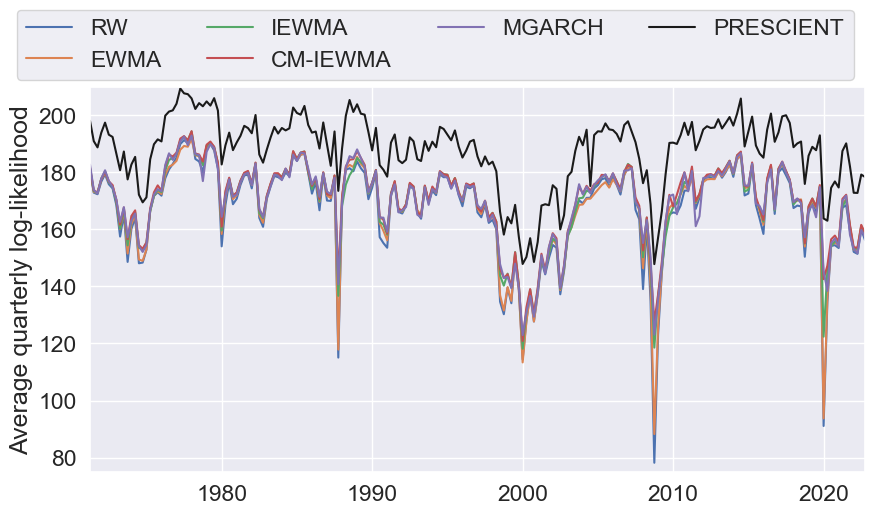

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.23), loc='upper right', ncols=4, labels=names, scatterpoints=1, markerscale=5)
plt.ylabel("Average quarterly log-likelihood")
plt.ylim(75,210);

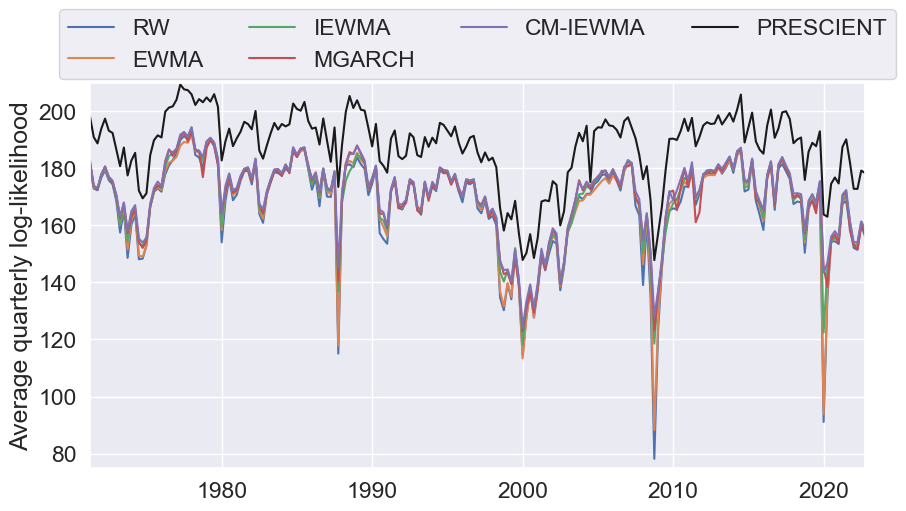

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5, )
plt.ylabel("Average quarterly log-likelihood")
plt.ylim(75,210);

# Regrets

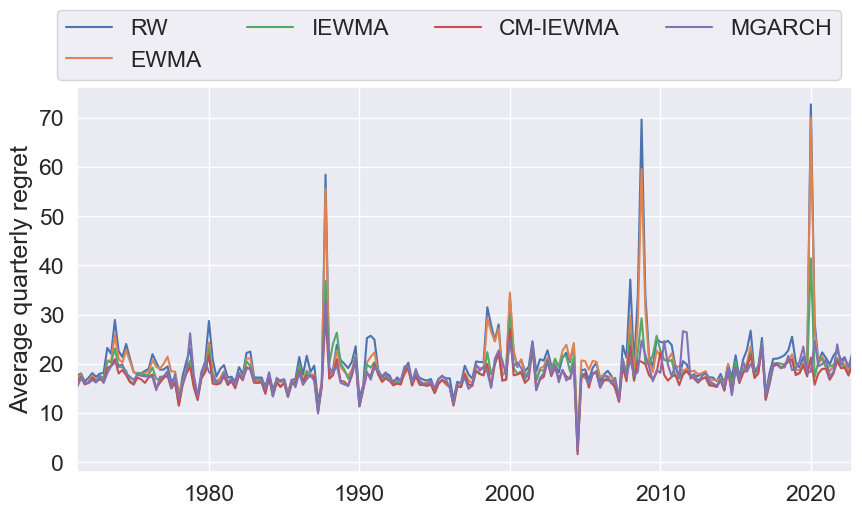

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.23), loc='upper right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5)
plt.ylabel("Average quarterly regret");
# plt.ylim(5,75);


### Compare CM-IEWMA with MGARCH

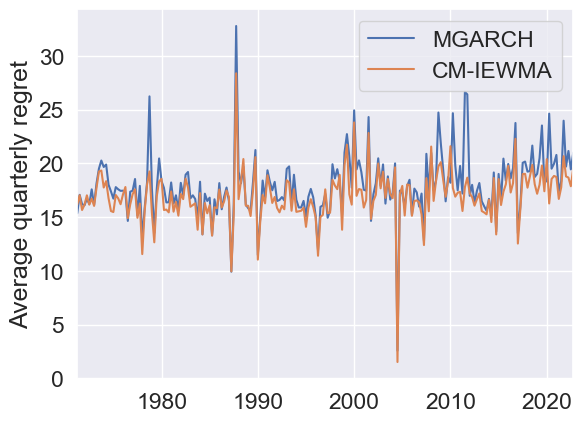

In [37]:
regret_mgarch = regrets["MGARCH"].resample("Q").mean()
regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()

regret_mgarch.plot(label="MGARCH")
regret_cm_iewma.plot(label="CM-IEWMA")
plt.ylabel("Average quarterly regret")
plt.legend();

In [19]:
cm_iewma_advantage = (regret_cm_iewma - regret_mgarch < 0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 87% of the time


### Regret CDF plots

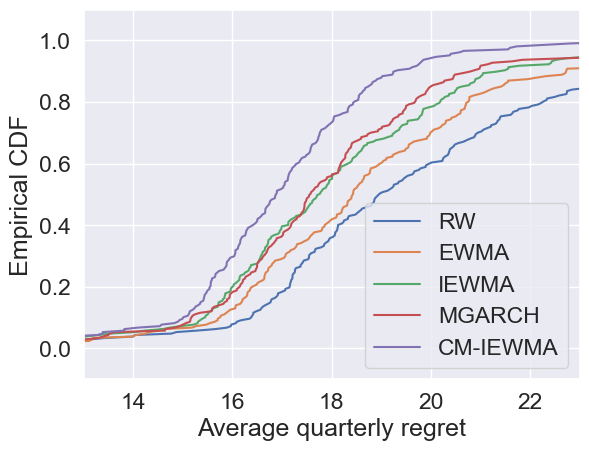

In [38]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(13,23)
plt.ylim(-0.1,1.1)
plt.xlabel("Average quarterly regret")
plt.ylabel("Empirical CDF")
plt.legend();

### Regret metrics

In [21]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   RW & 20.4 & 6.9 & 72.8 \\
   EWMA & 19.4 & 6.2 & 70.1 \\
   IEWMA & 18.2 & 3.6 & 41.4 \\
   MGARCH & 17.9 & 3.0 & 32.8 \\
   CM-IEWMA & 16.9 & 2.4 & 28.4 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


# Portfolio optimization

In [6]:
from cvx.backtest.portfolios import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons = {"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}
sigma_tar = 0.05
excess = True

In [18]:
additonal_cons = {"short_lim":2, "upper_bound":0.4,\
             "lower_bound":-0.3}

### Equally weighted

In [12]:
traders_eq_w = EqWeighted(returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


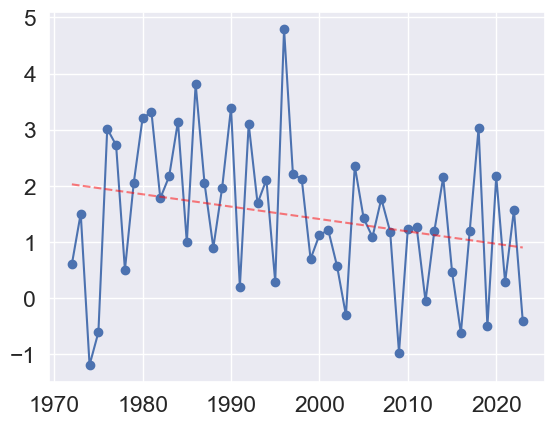

In [18]:
trader = traders_eq_w["CM-IEWMA"]
SRs = yearly_SR(trader)

In [14]:
create_table(traders_eq_w, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 2.2\% & 5.1\% & 0.4 & 13\% \\
   CM-IEWMA & 2.4\% & 5.0\% & 0.5 & 12\% \\
   \hline
   \bottomrule
\end{tabular}


In [24]:
create_table(traders_eq_w, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 2.2\% & 5.4\% & 0.4 & 16\% \\
   EWMA & 2.2\% & 5.1\% & 0.4 & 15\% \\
   IEWMA & 2.2\% & 5.1\% & 0.4 & 15\% \\
   MGARCH & 2.4\% & 5.1\% & 0.5 & 14\% \\
   CM-IEWMA & 2.3\% & 5.0\% & 0.5 & 13\% \\
   \hline
   PRESCIENT & 4.3\% & 4.9\% & 0.9 & 8\% \\
   \bottomrule
\end{tabular}


### Minimum risk

In [7]:
additonal_cons = {}

In [19]:
predictors=[cm_iewma]
names=["CM-IEWMA"]

In [20]:
start_date=[*cm_iewma.keys()][0]

In [21]:
traders_min_risk = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 1/1 [00:08<00:00,  8.52s/it]


In [22]:
# ETFs
create_table(traders_min_risk, sigma_tar, rf.loc[traders_min_risk[names[0]].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 6.5\% & 11.2\% & 0.6 & 29\% \\
   \hline
   \bottomrule
\end{tabular}


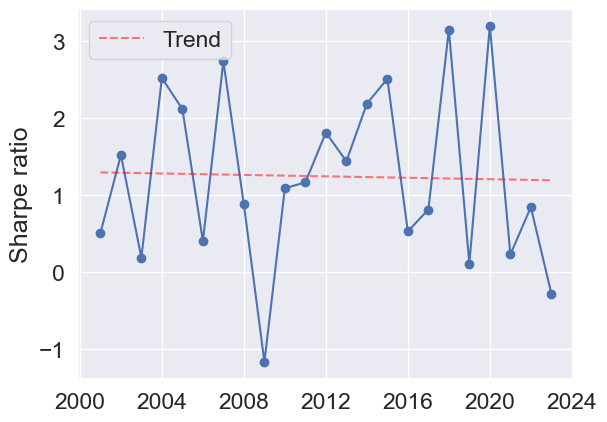

In [148]:
trader = traders_min_risk["Weighted"]
trader.returns = trader.R
SRs = yearly_SR(trader)

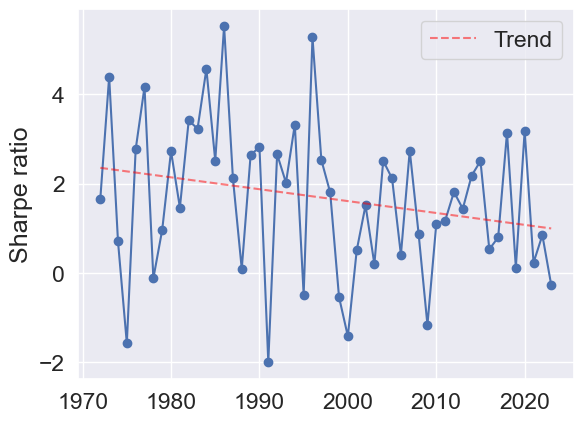

In [37]:
trader = traders_min_risk["CM-IEWMA"]
SRs = yearly_SR(trader)

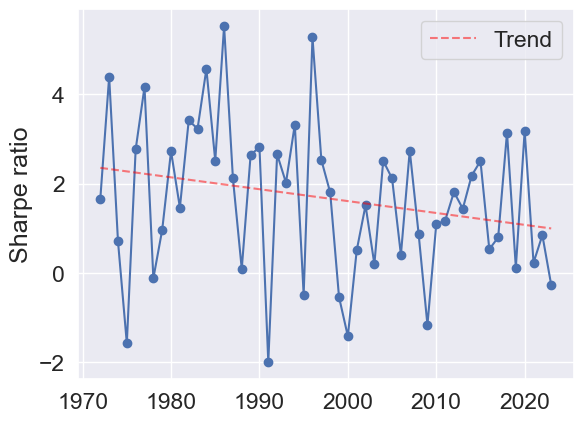

In [37]:
trader = traders_min_risk["CM-IEWMA"]
SRs = yearly_SR(trader)

In [62]:
# From 2000
create_table(traders_min_risk, sigma_tar, rf.loc[traders_min_risk[names[0]].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.3\% & 5.3\% & 0.8 & 14\% \\
   \hline
   \bottomrule
\end{tabular}


In [35]:
# From 2010
create_table(traders_min_risk, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 5.8\% & 5.2\% & 1.1 & 9\% \\
   \hline
   \bottomrule
\end{tabular}


In [26]:
create_table(traders_min_risk, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 3.1\% & 5.8\% & 0.5 & 23\% \\
   EWMA & 3.1\% & 5.4\% & 0.6 & 19\% \\
   IEWMA & 3.3\% & 5.5\% & 0.6 & 19\% \\
   MGARCH & 4.3\% & 6.1\% & 0.7 & 20\% \\
   CM-IEWMA & 3.5\% & 5.3\% & 0.7 & 20\% \\
   \hline
   PRESCIENT & 3.8\% & 5.0\% & 0.8 & 13\% \\
   \bottomrule
\end{tabular}


### Maximum diversification 

In [27]:
traders_max_diverse = MaxDiverse(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 6/6 [18:25<00:00, 184.23s/it]


In [28]:
create_table(traders_max_diverse, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 2.1\% & 5.5\% & 0.4 & 16\% \\
   EWMA & 2.1\% & 5.1\% & 0.4 & 16\% \\
   IEWMA & 2.2\% & 5.2\% & 0.4 & 14\% \\
   MGARCH & 2.5\% & 5.1\% & 0.5 & 12\% \\
   CM-IEWMA & 2.3\% & 5.0\% & 0.5 & 12\% \\
   \hline
   PRESCIENT & 3.8\% & 5.0\% & 0.8 & 10\% \\
   \bottomrule
\end{tabular}


### Risk parity 

In [29]:
traders_risk_par = RiskParity(returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 6/6 [14:46<00:00, 147.70s/it]


In [30]:
create_table(traders_risk_par, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 2.4\% & 5.4\% & 0.5 & 16\% \\
   EWMA & 2.4\% & 5.1\% & 0.5 & 15\% \\
   IEWMA & 2.5\% & 5.1\% & 0.5 & 14\% \\
   MGARCH & 2.7\% & 5.1\% & 0.5 & 14\% \\
   CM-IEWMA & 2.5\% & 5.0\% & 0.5 & 13\% \\
   \hline
   PRESCIENT & 4.7\% & 4.9\% & 1.0 & 8\% \\
   \bottomrule
\end{tabular}


### Mean variance

In [23]:
def tune_returns(returns, lower=0.4, upper=0.6):
    """
    Cuts element in each row at its 40th and 60th percentile
    up and down
    """
    
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.clip(r_temp, a_min=r_temp.quantile(lower), a_max=r_temp.quantile(upper))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)

In [8]:
def get_moving_autocorrelations(returns, return_predictions, halflife=125):
    return (returns*return_predictions).ewm(halflife=halflife).mean() / (np.sqrt((returns**2).ewm(halflife=halflife).mean()) * np.sqrt((return_predictions**2).ewm(halflife=halflife).mean()))

In [8]:
# mean_predictors = [r_hat_ewma for _ in range(len(predictors))]
return_predictor = get_moving_autocorrelations(returns, returns.shift(1), halflife=63) * returns

In [8]:
def get_sign_prediction(return_predictions):
    """
    Set ten largest positive predictions to 1 and ten largest negative
    predictions to -1 in each row
    """

    return_predictions_copy = return_predictions.copy()
        
    for i, r_temp in return_predictions_copy.iterrows():
        r_temp = r_temp.values.copy()
        # Set ten largest positive predictions to 1
        ten_largest = np.argsort(r_temp)[-10:]
        r_temp[ten_largest] = np.ones(10) * (r_temp[ten_largest]>0)

        # Set ten largest negative predictions to -1
        ten_smallest = np.argsort(r_temp)[:10]
        r_temp[ten_smallest] = -np.ones(10) * (r_temp[ten_smallest]<0)

        # Set other predictions to 0
        r_temp[np.where(np.abs(r_temp) != 1)] = np.zeros(len(np.where(np.abs(r_temp) != 1)))

        return_predictions_copy.loc[i] = r_temp
    
    return return_predictions_copy




In [24]:
start_date = pd.Timestamp("2000-01-03")

In [19]:
# From 2000
create_table(traders_min_risk, sigma_tar, rf.loc[traders_min_risk[names[0]].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 3.5\% & 5.5\% & 0.6 & 15\% \\
   \hline
   \bottomrule
\end{tabular}


In [20]:
# ECOS
create_table(traders_mean_var, None, rf.loc[traders_mean_var["IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & -0.1\% & 0.2\% & -0.4 & 1\% \\
   \hline
   \bottomrule
\end{tabular}


In [25]:
predictors = [cm_iewma]
names = ["CM-IEWMA"]

In [85]:
ewma21 = tune_returns(returns.ewm(halflife=21).mean(), lower=0.2, upper=0.8)
ewma63 = tune_returns(returns.ewm(halflife=63).mean(), lower=0.2, upper=0.8)
ewma125 = tune_returns(returns.ewm(halflife=125).mean(), lower=0.2, upper=0.8)
ewma250 = tune_returns(returns.ewm(halflife=250).mean(), lower=0.2, upper=0.8)
ewma500 = tune_returns(returns.ewm(halflife=500).mean(), lower=0.2, upper=0.8)


# For each entry, get the maximum deviation between any of the four EWMA
# predictors to the ewma250
max_deviation = np.max(np.abs(np.array([ewma63, ewma125]) - ewma250.values), axis=0)
rhos = pd.DataFrame(max_deviation, index=returns.index, columns=returns.columns)


In [95]:
ewma250 = tune_returns(returns.ewm(halflife=250).mean(), lower=0.4, upper=0.6)


In [80]:
ewma21 = returns.ewm(halflife=21).mean()
ewma63 = returns.ewm(halflife=63).mean()
ewma125 = returns.ewm(halflife=125).mean()
ewma250 = returns.ewm(halflife=250).mean()
ewma500 = returns.ewm(halflife=500).mean()

In [89]:
# Get the range of the four EWMA predictors

rhos = (np.max(np.array([ewma125, ewma250, ewma500]), axis=0) - np.min(np.array([ewma125, ewma250, ewma500]), axis=0)) / 2

predictor = np.mean(np.array([ewma125, ewma250, ewma500]), axis=0)

predictor = pd.DataFrame(predictor, index=returns.index, columns=returns.columns)
rhos = pd.DataFrame(rhos, index=returns.index, columns=returns.columns)

In [55]:
# ETFs
create_table(traders_min_risk, sigma_tar, rf.loc[traders_min_risk[names[0]].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.2\% & 5.4\% & 0.8 & 14\% \\
   \hline
   \bottomrule
\end{tabular}


In [54]:
# ETF ewma250 mean predictor 
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 2.9\% & 5.2\% & 0.6 & 10\% \\
   \hline
   \bottomrule
\end{tabular}


In [74]:
# ETF uncertainty with clipping, ewma 125, 250, 500
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 2.9\% & 5.2\% & 0.6 & 10\% \\
   \hline
   \bottomrule
\end{tabular}


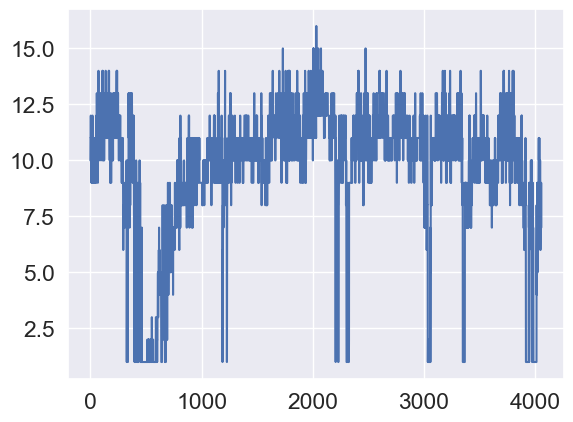

In [70]:
plt.plot(np.sum(traders_mean_var["CM-IEWMA"].ws > 0.0001, axis=1))

In [82]:
# ETFs min variance
create_table(traders_min_risk, sigma_tar, rf.loc[traders_min_risk[names[0]].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 8.4\% & 10.9\% & 0.8 & 27\% \\
   \hline
   \bottomrule
\end{tabular}


In [83]:
# MOSEK 
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 3.9\% & 10.7\% & 0.4 & 28\% \\
   \hline
   \bottomrule
\end{tabular}


In [99]:
# MOSEK 
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 16.3\% & 10.5\% & 1.6 & 11\% \\
   \hline
   \bottomrule
\end{tabular}


In [26]:
ewma250 = returns.ewm(halflife=250).mean()

In [28]:
# MOSEK 
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 5.4\% & 11.4\% & 0.5 & 30\% \\
   \hline
   \bottomrule
\end{tabular}


In [27]:
from experiments.utils.portfolio_backtests import *

# from cvx.backtest.portfolios import *

start_date = pd.Timestamp("2000-01-03")
start_date = [*cm_iewma.keys()][0]
# r_hat_ewma = pd.DataFrame(dict(_ewma_mean(returns, halflife=250))).T
# r_hat_ewma = tune_returns(r_hat_ewma)
# mean_predictors = [r_hat_ewma for name in names]
# mean_predictors = [r_hat_ewma for _ in range(len(predictors))]
# return_predictor = get_moving_autocorrelations(returns, returns.shift(1), halflife=125) * returns
# predictors = [cm_iewma, iewma]
additonal_cons = {}

mean_predictors = [ewma250]
# names = ["IEWMA", "CM-IEWMA"]

# max_deviation = np.max(np.abs(np.array([ewma125, ewma500]) - ewma250.values), axis=0)
# rhos = pd.DataFrame(max_deviation, index=returns.index, columns=returns.columns)
# uncertainties = rhos.shift(1)

traders_mean_var = MeanVariance(returns, predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar, rhos=None)

100%|██████████| 1/1 [00:12<00:00, 12.31s/it]


In [14]:
# MOSEK 
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.8\% & 5.1\% & 0.9 & 12\% \\
   \hline
   \bottomrule
\end{tabular}


In [64]:
# MOSEK ewma250
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 5.1\% & 5.7\% & 0.9 & 13\% \\
   \hline
   \bottomrule
\end{tabular}


In [60]:
# MOSEK ewma500
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.7\% & 5.6\% & 0.8 & 13\% \\
   \hline
   \bottomrule
\end{tabular}


In [58]:
# MOSEK rhos 125, 250, 500 No uncertainty
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.8\% & 5.8\% & 0.8 & 13\% \\
   \hline
   \bottomrule
\end{tabular}


In [56]:
# MOSEK rhos 125, 250, 500 tuned
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.8\% & 5.1\% & 0.9 & 12\% \\
   \hline
   \bottomrule
\end{tabular}


In [53]:
# MOSEK rhos 63, 125, 250, 500 tuned
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.2\% & 4.7\% & 0.9 & 11\% \\
   \hline
   \bottomrule
\end{tabular}


In [50]:
# MOSEK rhos 21, 63, 125, 250, 500 tuned
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 2.8\% & 4.1\% & 0.7 & 9\% \\
   \hline
   \bottomrule
\end{tabular}


In [46]:
# MOSEK rhos 125, 250, 500 
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 3.6\% & 6.0\% & 0.6 & 17\% \\
   \hline
   \bottomrule
\end{tabular}


In [43]:
# MOSEK rhos 63, 125, 250, 500 
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 3.7\% & 5.9\% & 0.6 & 16\% \\
   \hline
   \bottomrule
\end{tabular}


In [34]:
# MOSEK rhos 21, 63, 125, 250, 500 
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 3.5\% & 5.5\% & 0.6 & 17\% \\
   \hline
   \bottomrule
\end{tabular}


In [24]:
# MOSEK rhos 125, 250, 500 tuned
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 2.0\% & 4.8\% & 0.4 & 12\% \\
   \hline
   \bottomrule
\end{tabular}


In [21]:
# MOSEK rhos 21, 63, 125, 250, 500 tuned
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 1.7\% & 4.6\% & 0.4 & 16\% \\
   \hline
   \bottomrule
\end{tabular}


In [17]:
# MOSEK rhos 125, 250, 500
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 0.4\% & 5.2\% & 0.1 & 18\% \\
   \hline
   \bottomrule
\end{tabular}


In [14]:
# MOSEK rhos 63, 125, 250
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 0.9\% & 5.2\% & 0.2 & 18\% \\
   \hline
   \bottomrule
\end{tabular}


In [41]:
# MOSEK rhos 21, 63, 125, 250
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 1.2\% & 4.9\% & 0.2 & 15\% \\
   \hline
   \bottomrule
\end{tabular}


In [30]:
# MOSEK rhos 125, 500 with 250 as predictor (no tuning)
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.1\% & 5.7\% & 0.7 & 14\% \\
   \hline
   \bottomrule
\end{tabular}


In [27]:
# MOSEK rhos 125, 500 with 250 as predictor
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.3\% & 4.9\% & 0.9 & 11\% \\
   \hline
   \bottomrule
\end{tabular}


In [24]:
# MOSEK rhos 63, 250 with 125 as predictor
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 3.7\% & 4.8\% & 0.8 & 12\% \\
   \hline
   \bottomrule
\end{tabular}


In [21]:
# MOSEK rhos 63, 125
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 3.6\% & 4.4\% & 0.8 & 7\% \\
   \hline
   \bottomrule
\end{tabular}


In [17]:
# MOSEK rhos 21, 63, 125
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 1.5\% & 3.5\% & 0.4 & 10\% \\
   \hline
   \bottomrule
\end{tabular}


In [12]:
# MOSEK no rhos
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 5.1\% & 5.7\% & 0.9 & 13\% \\
   \hline
   \bottomrule
\end{tabular}


In [29]:
# MOSEK rhos
create_table(traders_mean_var, None, rf.loc[traders_mean_var["IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 1.3\% & 3.4\% & 0.4 & 11\% \\
   \hline
   \bottomrule
\end{tabular}


In [27]:
# MOSEK no rhos
create_table(traders_mean_var, None, rf.loc[traders_mean_var["IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 4.2\% & 5.8\% & 0.7 & 14\% \\
   \hline
   \bottomrule
\end{tabular}


In [17]:
# MOSEK rhos
create_table(traders_mean_var, None, rf.loc[traders_mean_var["IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 1.7\% & 4.9\% & 0.3 & 15\% \\
   \hline
   \bottomrule
\end{tabular}


In [14]:
# MOSEK no rhos
create_table(traders_mean_var, None, rf.loc[traders_mean_var["IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 2.4\% & 6.1\% & 0.4 & 20\% \\
   \hline
   \bottomrule
\end{tabular}


In [11]:
# MOSEK no rhos
create_table(traders_mean_var, None, rf.loc[traders_mean_var["IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 2.9\% & 6.6\% & 0.4 & 22\% \\
   \hline
   \bottomrule
\end{tabular}


In [11]:
# MOSEK rhos
create_table(traders_mean_var, None, rf.loc[traders_mean_var["IEWMA"].returns.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 1.5\% & 4.8\% & 0.3 & 13\% \\
   \hline
   \bottomrule
\end{tabular}


In [75]:
index=return_predictor.shift(1).dropna().index
np.corrcoef(np.sign(return_predictor.shift(1).dropna().values.flatten()), returns.loc[index].values.flatten())

array([[1.        , 0.05918507],
       [0.05918507, 1.        ]])

In [ ]:
set(cm_iewma.keys()).issubset(set(mean_predictor.index))

In [10]:
# No tune robust 2 stdev
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].R.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 2.0\% & 5.5\% & 0.4 & 22\% \\
   CM-IEWMA & 2.5\% & 5.4\% & 0.5 & 19\% \\
   \hline
   \bottomrule
\end{tabular}


In [10]:
# No tune robust 1 stdev
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].R.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 2.4\% & 6.1\% & 0.4 & 20\% \\
   CM-IEWMA & 3.5\% & 5.9\% & 0.6 & 15\% \\
   \hline
   \bottomrule
\end{tabular}


In [10]:
# No tune
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].R.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 2.9\% & 6.6\% & 0.4 & 22\% \\
   CM-IEWMA & 3.9\% & 6.3\% & 0.6 & 20\% \\
   \hline
   \bottomrule
\end{tabular}


In [24]:
# Tune
create_table(traders_mean_var, None, rf.loc[traders_mean_var["CM-IEWMA"].R.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   IEWMA & 4.2\% & 5.8\% & 0.7 & 14\% \\
   CM-IEWMA & 5.1\% & 5.7\% & 0.9 & 13\% \\
   \hline
   \bottomrule
\end{tabular}


In [10]:
create_table(traders_mean_var, None, rf.loc[traders_mean_var["Weighted"].R.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Weighted & 2.9\% & 6.9\% & 0.4 & 21\% \\
   \hline
   \bottomrule
\end{tabular}


In [19]:
create_table(traders_mean_var, None, rf.loc[traders_mean_var["Weighted"].R.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Weighted & 2.1\% & 5.3\% & 0.4 & 32\% \\
   \hline
   \bottomrule
\end{tabular}


In [79]:
create_table(traders_mean_var, None, rf.loc[traders_mean_var["Autocorr"].R.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Autocorr & 4.7\% & 5.8\% & 0.8 & 12\% \\
   \hline
   \bottomrule
\end{tabular}


In [64]:
create_table(traders_mean_var, None, rf.loc[traders_mean_var["Autocorr"].R.index], excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Autocorr & 3.2\% & 5.3\% & 0.6 & 35\% \\
   \hline
   \bottomrule
\end{tabular}


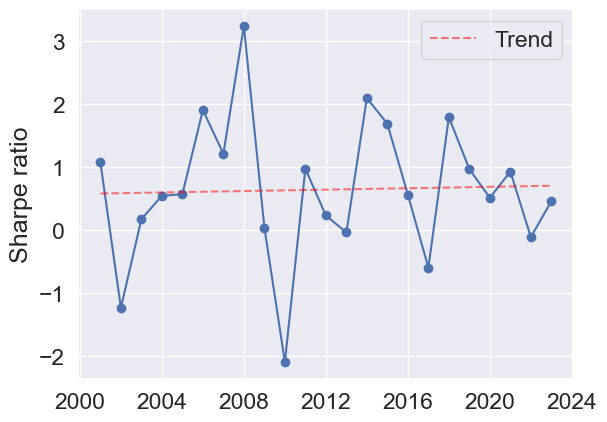

In [11]:
trader = traders_mean_var["Weighted"]
trader.returns = trader.R
SRs = yearly_SR(trader)

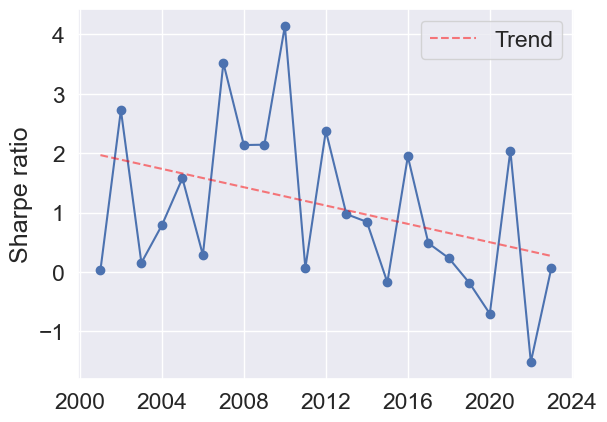

In [141]:
trader = traders_mean_var["Weighted"]
trader.returns = trader.R
SRs = yearly_SR(trader)

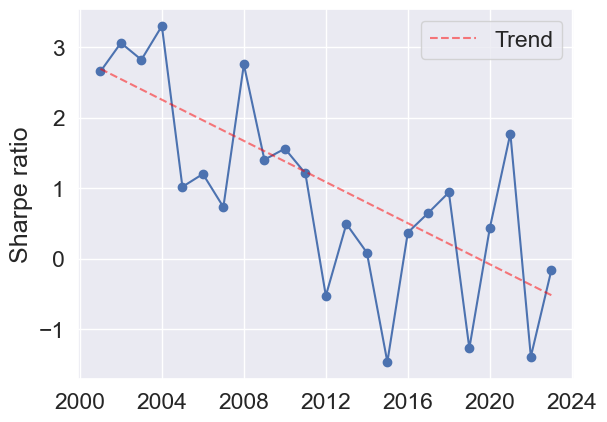

In [71]:
trader = traders_mean_var["Autocorr"]
trader.returns = trader.R
SRs = yearly_SR(trader)

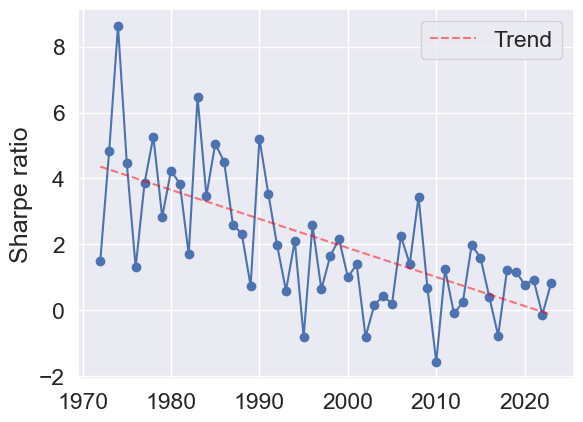

In [38]:
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)

In [33]:
SRs.loc["2000-01-01":].mean()

0.7366292698078497

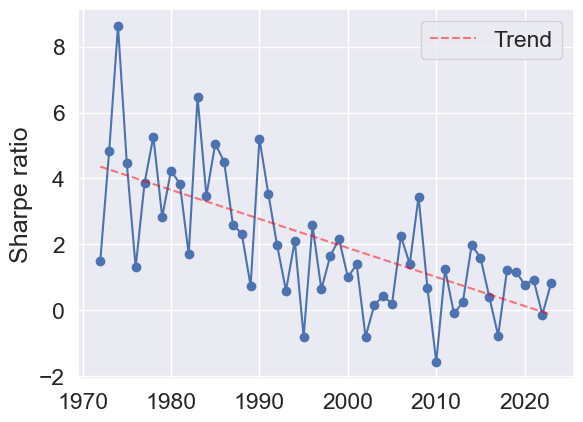

In [38]:
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)

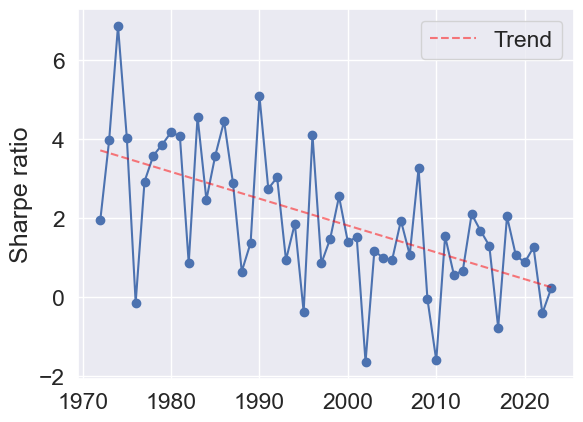

In [17]:
trader = traders_mean_var["No clip"]
SRs = yearly_SR(trader)

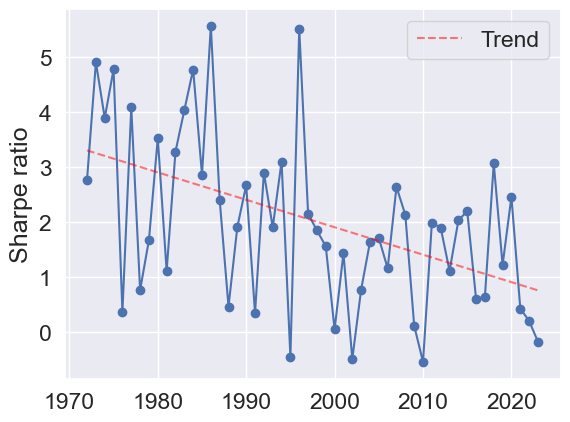

In [19]:
trader = traders_mean_var["clip"]
SRs = yearly_SR(trader)

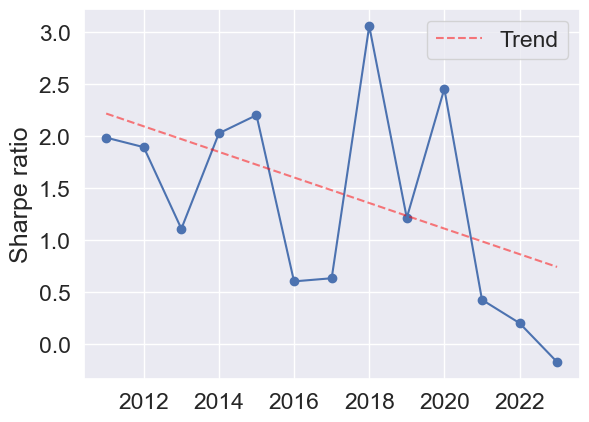

In [40]:
trader = traders_mean_var["clip"]
SRs = yearly_SR(trader)

In [33]:
SRs.loc["2000-01-01":].mean()

0.7366292698078497

In [39]:
# 250 
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   No clip & 5.4\% & 6.5\% & 0.8 & 11\% \\
   clip & 6.6\% & 5.7\% & 1.2 & 9\% \\
   \hline
   \bottomrule
\end{tabular}


In [37]:
# 63 day
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   No clip & 4.2\% & 6.7\% & 0.6 & 11\% \\
   clip & 3.7\% & 5.7\% & 0.6 & 12\% \\
   \hline
   \bottomrule
\end{tabular}


In [16]:
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   No clip & 6.7\% & 6.0\% & 1.1 & 20\% \\
   clip & 6.1\% & 5.6\% & 1.1 & 13\% \\
   \hline
   \bottomrule
\end{tabular}


In [32]:
create_table(traders_mean_var, None, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 7.1\% & 7.1\% & 1.0 & 25\% \\
   EWMA & 6.8\% & 6.7\% & 1.0 & 23\% \\
   IEWMA & 7.3\% & 6.5\% & 1.1 & 20\% \\
   MGARCH & 8.6\% & 6.6\% & 1.3 & 18\% \\
   CM-IEWMA & 7.4\% & 6.2\% & 1.2 & 16\% \\
   \hline
   PRESCIENT & 3.4\% & 4.6\% & 0.7 & 18\% \\
   \bottomrule
\end{tabular}


In [69]:
create_table(traders_mean_var, None, rf, excess, prescient=True)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 5.6\% & 6.2\% & 0.9 & 16\% \\
   EWMA & 5.6\% & 5.8\% & 1.0 & 15\% \\
   IEWMA & 5.9\% & 5.7\% & 1.0 & 14\% \\
   MGARCH & 6.7\% & 6.4\% & 1.0 & 14\% \\
   CM-IEWMA & 6.1\% & 5.6\% & 1.1 & 13\% \\
   \hline
   PRESCIENT & 4.6\% & 5.0\% & 0.9 & 10\% \\
   \bottomrule
\end{tabular}


In [16]:
create_table(traders_mean_var, None, rf, excess, prescient=True)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 5.6\% & 6.2\% & 0.9 & 16\% \\
   EWMA & 5.6\% & 5.8\% & 1.0 & 15\% \\
   IEWMA & 5.9\% & 5.7\% & 1.0 & 14\% \\
   MGARCH & 6.7\% & 6.4\% & 1.0 & 14\% \\
   CM-IEWMA & 6.1\% & 5.6\% & 1.1 & 13\% \\
   \hline
   PRESCIENT & 4.6\% & 5.0\% & 0.9 & 10\% \\
   \bottomrule
\end{tabular}


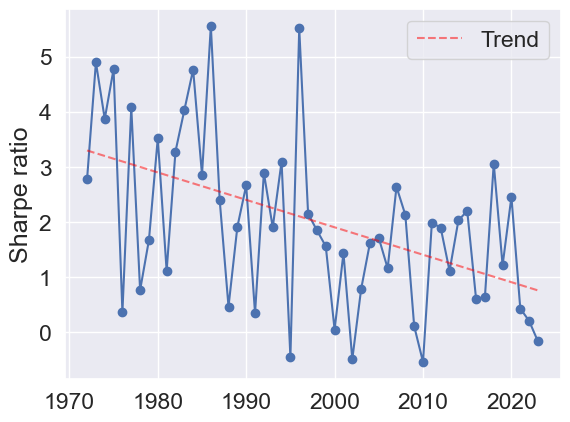

In [24]:
trader = traders_mean_var["CM-IEWMA"]
trader.returns = trader.R
SRs = yearly_SR(trader)